Count done
tensor([77420.,   103.,   144.,   353.,  1473.,   179.,   441.])
8 219
0 2
0 2
0 4
0 11
0 4
0 5


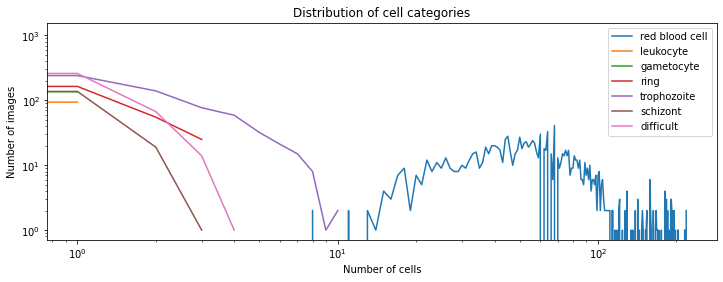

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

df_training = pd.read_json("/home/jacopo/repo/hshap/data/malaria/training.json")
df_test = pd.read_json("/home/jacopo/repo/hshap/data/malaria/test.json")

class_dict = {
    "red blood cell": 0,
    "leukocyte": 1,
    "gametocyte": 2,
    "ring": 3,
    "trophozoite": 4,
    "schizont": 5,
    "difficult": 6
}

L = len(df_training)
q = len(class_dict)
cells_count = torch.zeros((L, q))

train_ring = {0:[], 1:[]}
train_trophozoite = {0:[], 1:[]}

for i, image in df_training.iterrows():
    image_name = os.path.basename(image["image"]["pathname"])
    cells = image["objects"]
    for cell in cells:
        cell_class = cell["category"]
        cells_count[i, class_dict[cell_class]] += 1
        
    if cells_count[i, class_dict["ring"]] >= 1:
        train_ring[1].append(image_name)
    else:
        train_ring[0].append(image_name)
    
    if cells_count[i, class_dict["trophozoite"]] >= 1:
        train_trophozoite[1].append(image_name)
    else:
        train_trophozoite[0].append(image_name)

L = len(df_test)
q = len(class_dict)
test_cells_count = torch.zeros((L, q))
test_ring = {0:[], 1:[]}
test_trophozoite = {0:[], 1:[]}
for i, image in df_test.iterrows():
    image_name = os.path.basename(image["image"]["pathname"])
    cells = image["objects"]
    for cell in cells:
        cell_class = cell["category"]
        test_cells_count[i, class_dict[cell_class]] += 1
        
    if test_cells_count[i, class_dict["ring"]] >= 1:
        test_ring[1].append(image_name)
    else:
        test_ring[0].append(image_name)
    
    if test_cells_count[i, class_dict["trophozoite"]] >= 1:
        test_trophozoite[1].append(image_name)
    else:
        test_trophozoite[0].append(image_name)
        
print("Count done")
print(torch.sum(cells_count, 0))

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1,1)

for cell_class in class_dict:
    i = class_dict[cell_class]
    cell_class_count = cells_count[:, i]
    _min = int(torch.min(cell_class_count).item())
    _max = int(torch.max(cell_class_count).item())
    print(_min, _max)
    histc = torch.histc(cell_class_count, bins=_max-_min, min=_min, max=_max).numpy()
    ax.plot(np.arange(_min, _max), histc, label=cell_class)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of cells")
ax.set_ylabel("Number of images")
ax.set_title("Distribution of cell categories")
ax.legend()
plt.savefig("distribution.png")

In [3]:
print("The rule is: 'there is at least one ring cell'")
print("positive training samples: {}, negative training samples: {}".format(len(train_ring[1]), len(train_ring[0])))
print("positive test samples: {}, negative test samples: {}".format(len(test_ring[1]), len(test_ring[0])))
print("\nThe rule is: 'there is at least one trophozoite cell'")
print("positive training samples: {}, negative training samples: {}".format(len(train_trophozoite[1]), len(train_trophozoite[0])))
print("positive test samples: {}, negative test samples: {}".format(len(test_trophozoite[1]), len(test_trophozoite[0])))

The rule is: 'there is at least one ring cell'
positive training samples: 244, negative training samples: 964
positive test samples: 57, negative test samples: 63

The rule is: 'there is at least one trophozoite cell'
positive training samples: 596, negative training samples: 612
positive test samples: 59, negative test samples: 61


In [4]:
np.save("train_ring.npy", train_ring)
np.save("train_trophozoite.npy", train_trophozoite)
np.save("test_ring.npy", test_ring)
np.save("test_trophozoite.npy", test_trophozoite)